In [1]:
import math
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from IPython.display import display
#import multiprocessing

In [2]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


In [3]:
# function convert series to supervised learning
def series_to_supervised(data, time, n_in=1, lag=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    cols.append(pd.DataFrame(time))
    names.append('time')
    # input sequence (t-n-lag, ... t-lag)
    for i in range(n_in+lag-1, lag-1, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast t
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    array = np.concatenate((X,yhat), axis=1)
    inverted = scaler.inverse_transform(array)
    return inverted[:, -1]


In [4]:
def fit_lstm(train, test, batch_size, nb_epoch, neurons, timesteps, dropout_rate, N_hidden_layers):
    X, y = train[:, 0:-1], train[:, -1]
    X_val, y_val = test[:, 0:-1], test[:, -1]
    X = X.reshape(X.shape[0], timesteps, 1)
    X_val = X_val.reshape(X_val.shape[0], timesteps, 1)

    train = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size)
    train = train.cache()
    val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
    val = val.cache()

    with strategy.scope():
        model = Sequential()
        model.add(LSTM(units = neurons, input_shape = (X.shape[1], 1), return_sequences=True))
        model.add(Dropout(dropout_rate))

        for k in range(1, N_hidden_layers-1):
            model.add(LSTM(units = neurons, return_sequences=True))
            model.add(Dropout(dropout_rate))

        model.add(LSTM(units = neurons))
        model.add(Dropout(dropout_rate))

        model.add(Dense(units = 1))
        model.compile(loss='mean_squared_error', optimizer='adam')
    # fit the model to the batch each epoch and reset the state of network at the end of each epoch manually
    #model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, batch_size=batch_size, verbose=False)
    model.fit(train, validation_data=val, epochs=nb_epoch, verbose=0)
    return model

# make a one-step forecast
def forecast_lstm(model, X):
	X = X.reshape(X.shape[0], X.shape[1], 1)
	yhat = model.predict(X)
	return yhat


In [5]:
def simulation(data, time, timesteps, lag, num_train, epochs):
    data = series_to_supervised(data, time, timesteps, lag)
    scaler, train, test = scale(data.iloc[:num_train,1:].values,data.iloc[num_train:,1:].values)
    # Plots real data
    plt.plot(data.iloc[:,0], data.iloc[:,-1],
        color = 'red', 
        label = 'Real TESLA Stock Price')

    for hidden_layers, neurons, batch_size, dropoutRate in [(4,50,64*4,0.2),(2,50,64*4,0.2),(4,100,64*4,0.2), (4,50,64*4,0.5)]:
        # Model construction and fitting
        model = fit_lstm(train, test, batch_size, epochs, neurons, timesteps, dropoutRate, hidden_layers)

        # Model prediction for testing dat
        X, y = train[:, 0:-1], train[:, -1]
        yhat = forecast_lstm(model, X)
        yhat1 = invert_scale(scaler, X, yhat)
        X, y = test[:, 0:-1], test[:, -1]
        yhat = forecast_lstm(model, X)
        yhat2 = invert_scale(scaler, X, yhat)
        predictions = np.concatenate((yhat1,yhat2))
        plt.plot(data.iloc[:,0], predictions,
            label = 'layers=%d, neurons=%d, batch size=%d, dropout rate=%.1f' %(hidden_layers, neurons, batch_size, dropoutRate))

    plt.xticks(np.arange(0,len(predictions),300))
    plt.title('TESLA Stock Price Prediction with time lag = %d' % lag)
    plt.xlabel('Time')
    plt.ylabel('TESLA Stock Price')
    leg = plt.legend(loc='upper center', ncol=2, shadow=True, fancybox=True, bbox_to_anchor=(0.5, -0.05))
    leg.get_frame().set_alpha(0.5)
    plt.show()

    #return pd.DataFrame(summary, columns = ['lag', 'batch size', 'dropout rate', 'MSE: train', 'MSE: test'])

## Load and inspect the data

In [6]:
df=pd.read_csv("TSLA.csv")
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (1328, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-09,51.816002,52.590000,51.358002,51.584000,51.584000,16670500
1,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
2,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
3,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
4,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000


## Fit LSTM model with timesteps=350, epochs=50, number of training = 850 and other settings in figures below
- Note that in stock market, there is no trade on weekend. Time lag of 7 days is actually 5 days in the data. Time lag of 14 days is actually 10 days.

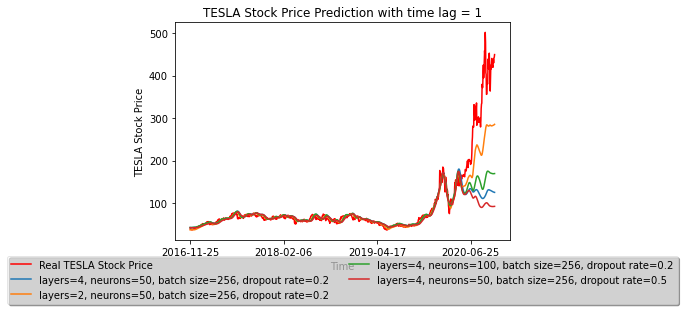

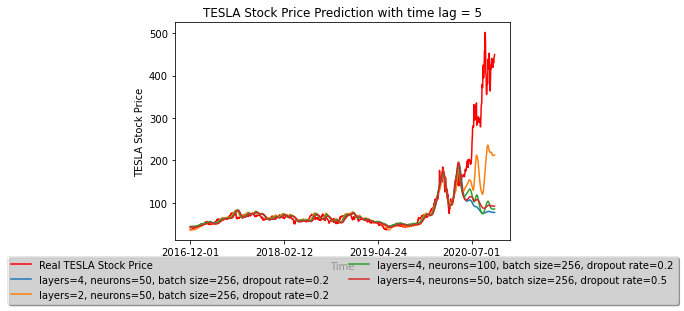

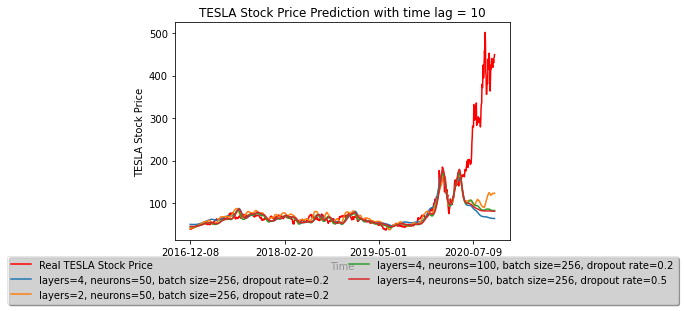

In [8]:
for lag in [1,5,10]: # Actually 1 day, 7 days and 14 days
    simulation(data=list(df.iloc[:, 1].values), time=list(df.iloc[:, 0].values), 
        timesteps=350, lag=lag, num_train=850, epochs=50)


- In all 4 settings, the model with layers=2 with 50 neurons each and batch size=256 and dropout rate=20% performed best.
- More neurons in each layer increased the performance a little bit.
- Larger dropout rate can help as time lag becomes larger.
- The larger time lag, the worse the prediction performance.

## We use the model with best performance when time lag = 2 weeks and predict TESLA stock price from 2020-10-15 to 2020-10-28

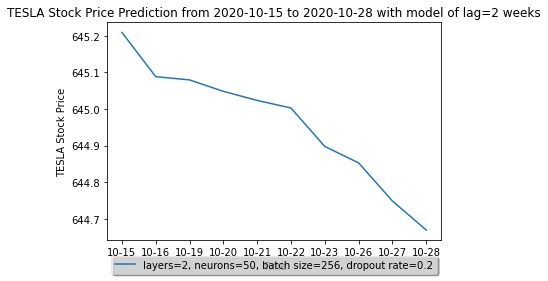

In [31]:
timesteps=350
epochs=50
data = series_to_supervised(data=list(df.iloc[:, 1].values), time=list(df.iloc[:, 0].values), n_in=timesteps, lag=10)
scaler, train, test = scale(data.iloc[:,1:].values,data.iloc[:,1:].values)
hidden_layers, neurons, batch_size, dropoutRate = 2,50,64*4,0.2
# Model construction and fitting
model = fit_lstm(train, test, batch_size, epochs, neurons, timesteps, dropoutRate, hidden_layers)
# Model prediction for next 2 weeks
ExistVals = np.array(df.iloc[:, 1].values)
X = []
for i in range(len(ExistVals)-10,len(ExistVals)):
    X.append(ExistVals[i-timesteps:i])
X = np.array(X)
yhat = forecast_lstm(model, X)
yhat2 = invert_scale(scaler, X, yhat)
predictions = yhat2
plt.plot(['10-15', '10-16', '10-19', '10-20', 
    '10-21', '10-22', '10-23', '10-26', 
    '10-27', '10-28'], predictions,
    label = 'layers=%d, neurons=%d, batch size=%d, dropout rate=%.1f' %(hidden_layers, neurons, batch_size, dropoutRate))

plt.title('TESLA Stock Price Prediction from 2020-10-15 to 2020-10-28 with model of lag=2 weeks')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
leg = plt.legend(loc='upper center', ncol=2, shadow=True, fancybox=True, bbox_to_anchor=(0.5, -0.05))
leg.get_frame().set_alpha(0.5)
plt.show()



Our prediction shows the price will slip down. It is exact the trend of TESLA during 10-15 to 10-28, although the prices are not precise.